In [1]:
import line_profiler
%load_ext line_profiler

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sqlalchemy as sqla
from sklearn.decomposition import PCA, kernel_pca
from sklearn.mixture import GMM
import itertools as it
import seaborn as sns

In [4]:
%matplotlib inline
plt.style.use('ggplot')

In [143]:
class Steps(object):
    def __init__(self, source, db, threshold=1000):
        self.engine = sqla.create_engine('sqlite:///{}'.format(db)) #steps.db
        self.source = source #'steps.csv'
        self.threshold = threshold
        #self.store()
        self._data = None
        
    def store(self):
        df = pd.read_csv(self.source, names=[u'Start', u'Finish', u'Steps'], skiprows=1)
        df.drop(u'Finish', 1, inplace=True)
        df[u'Start'] = pd.to_datetime(df[u'Start'])
        df.to_sql(u'data', con=self.engine, if_exists='replace', 
                  index=False, dtype={u'Steps':sqla.sql.sqltypes.INTEGER, u'Start':sqla.sql.sqltypes.DATETIME}) #, index_label=u'Start')

    @property
    def data(self):
        if not isinstance(self._data, pd.DataFrame):
            df = pd.read_sql('SELECT * FROM data WHERE Steps < {}'.format(self.threshold), self.engine)
            df.index = pd.to_datetime(df[u'Start'])
            self._data = df
        return self._data
    
    def pivot(self, freq):
        pivot = self.data
        pivot = pivot.resample(freq, how="sum")\
                     .apply(lambda x: x.groupby([x.index.date, x.index.time]).sum()).unstack().fillna(0)
        pivot.index = pd.to_datetime(pivot.index)
        return pivot[u'Steps']
    
    def clusters(self, freq, n_cluster):
        df = self.pivot(freq)
        gmm = GMM(n_cluster, covariance_type='full', random_state=0)
        Xpca = PCA(n_components = n_cluster).fit_transform(df.values)
        gmm.fit(Xpca)
        return pd.Series(gmm.predict(Xpca), index=df.index, name='cluster')
    
    def plot_cluster(self, freq, n_cluster, qtle_plot=0.99, n_col=2):    
        def pos(i):
            if n_cluster <= n_col:
                return i % n_col
            else:
                return (i // n_col, i % n_col)

        daily = self.pivot(freq)
        daily['cluster'] = self.clusters(freq, n_cluster)
        daily['weekday'] = daily.index.dayofweek
        by_cluster = daily.groupby([u'cluster']).mean().drop('weekday',1)

        fig, axarr = plt.subplots(n_cluster/n_col, n_col, figsize=(14, 10), sharex=True, sharey=True)
        hourly_ticks = 4 * 60 * 60 * np.arange(7)
        y_max = daily.ix[:,:-2].quantile(qtle_plot, axis=0).max()

        for i in range(n_cluster):
            palette = it.cycle(sns.color_palette())
            cluster_data = daily.query('cluster == {}'.format(i))
            cluster_data.ix[:,:-2].mean().plot(ax=axarr[pos(i)], xticks=hourly_ticks)#color=[next(palette)])
            count = []
            for b in [True, False]:
                df = cluster_data.query('(weekday < 5) == {}'.format(b))
                count.append(len(df.index))
                if not df.empty:
                    df.ix[:,:-2].T.plot(ax=axarr[pos(i)], legend=False, color=[next(palette)], alpha=0.1)
            axarr[pos(i)].set_title('Cluster {} ({} days / {:.0%} weekdays)'\
                                        .format(i, sum(count), 1.0*count[0]/sum(count)))
            axarr[pos(i)].set_ylabel('Steps every {}'.format(freq.lower()))
            axarr[pos(i)].set_ylim(ymax=y_max)
        fig.tight_layout()
        
    def cluster_specs(self, freq, n_cluster, window):
        data = pd.concat([self.clusters(freq, n_cluster), self.data.resample('1D', how='sum')], axis=1)
        data_mean = data.pivot_table(values=['Steps'], 
                                         index=data.index,
                                         columns=['cluster']).fillna(method='pad').fillna(0)\
                                      .apply(pd.rolling_mean, window=window, min_periods=1)
        data_count = data.pivot_table(values=['Steps'], 
                                         index=data.index,
                                         columns=['cluster'])\
                                      .apply(pd.rolling_count, window=window)
        data_mean.columns = data_mean.columns.set_levels(['mean'], level=0)
        data_count.columns = data_count.columns.set_levels(['count'], level=0)
        return pd.concat([data_mean, data_count], axis=1)

    def plot_cluster_specs(self, freq, n_cluster, window=30):
        fig, axarr = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=False)
        data = self.cluster_specs(freq, n_cluster, window)
        data['count'].plot(ax=axarr[0])
        data['mean'].plot(ax=axarr[1])
        plt.show()
    
steps = Steps('steps.csv', 'steps.db')

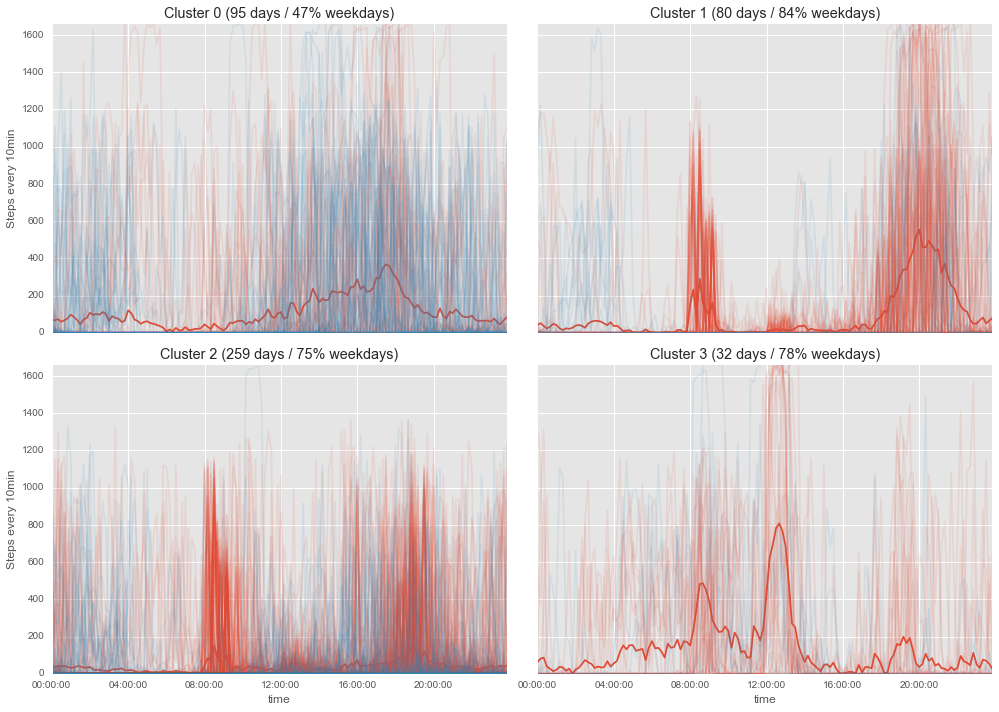

In [150]:
steps.plot_cluster('10Min', 4)

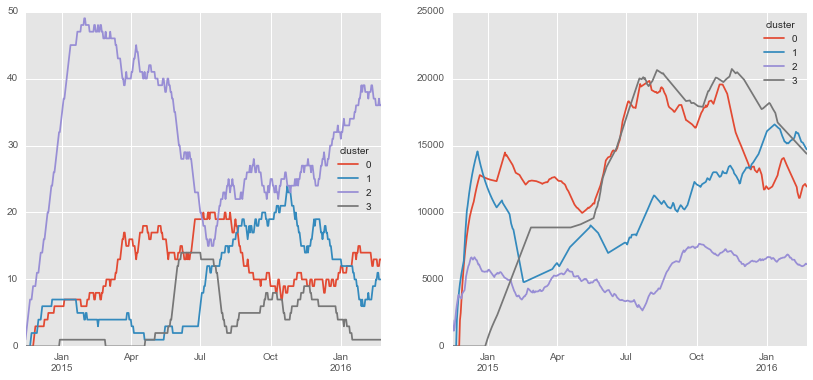

In [153]:
steps.plot_cluster_specs('10Min', 4, 60)

In [54]:
steps.data
%lprun -f Steps.pivot steps.clusters("1H", 4)

In [ ]:
X = daily.values
Xpca = PCA(n_components = 7).fit_transform(X)
total_steps = X.sum(axis = 1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_steps, cmap='RdYlBu')
plt.colorbar(label='total steps')

In [ ]:
n_cluster = 3
gmm = GMM(n_cluster, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
for pair in it.combinations(range(n_cluster), 2):
    plt.scatter(Xpca[:, pair[0]], Xpca[:,  pair[1]], c=cluster_label, cmap ="RdYlBu")
    plt.show()

In [ ]:
pivoted = df.pivot_table([u'Steps'], index =df.index.date, columns = df.index.time, fill_value = 0)
pivoted.index = pd.to_datetime(pivoted.index)

In [ ]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
#is_weekend = (pd.to_datetime(pivoted.index).dayofweek) > 4
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('hsv', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
#cb.set_ticklabels(['False', 'True'])
plt.clim(-0.5, 6.5);

In [ ]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

In [ ]:
by_weekday = results.groupby(['cluster', 'weekday']).count().unstack(level=0)['is_weekend']
print by_weekday
sns.heatmap(by_weekday)
by_weekday.plot(kind = 'bar')
by_weekday.sum(axis = 0).plot(kind= 'bar')

In [ ]:
def htmp(pivot, freq):
    df0_ = df.resample("1H", how = "sum").fillna(0, inplace = False)
    pivot_ = df0_.pivot_table([u'Steps'], index =df0_.index.date, columns = df0_.index.time, fill_value = 0)
    pivot_.index = pd.to_datetime(pivot_.index)
    pivot_ = pivot_.resample(freq, how= "sum")
    ax = sns.heatmap(pivot_,  yticklabels=False, xticklabels =False)
    plt.show()
    ax = sns.kdeplot(pivot_, n_levels=30, cmap="Purples_d")
    plt.show()
[htmp(pivoted, freq) for freq in ['M','W']] # ['D', 'W', 'M']


In [ ]:
df0_ = df.resample("H", how = "mean").fillna(0, inplace = False)
df0_ = df0_.groupby(df0_.index.weekday).mean()
plt.scatter(x= df0_.index, y=df0_.values)
plt.xlim([-0.1,6.1])
plt.ylim([0,np.max(df0_.values)*1.2])
plt.xticks(range(7),['M','T','W', 'T', 'F', 'S','S'] )
plt.show()

In [ ]:
def distr(str):
    ax = sns.kdeplot(df0[u'Steps'].resample(str, how= "sum"))
    ax = sns.distplot(np.sort(df0[u'Steps'].resample(freq, how= "sum").values))
    plt.xlim([0,np.max(df0[u'Steps'].resample(str, how= "sum"))*1.2])
    plt.show()
[distr(freq) for freq in ["D", "W", "M"]]

In [ ]:
daily_c